In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
import matplotlib.animation as animation
from tqdm import tqdm
#from scipy.optimize import minimize
#from scipy import optimize
#from jax.scipy.optimize import minimize
#from jax.scipy import optimize
#from scipy.linalg import circulant
#from scipy import fft
from joblib import Parallel, delayed
#import torch
#from cycler import cycler
#import torchvision
import cProfile
#from scipy import special
#from scipy.linalg import qr
#from scipy import sparse
import pickle 
import os


import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [39]:
def log_downsample_indices(total_points, num_points=1000):
    """
    Generate logarithmically spaced indices for downsampling.
    The indices are computed in the range [1, total_points] then converted to zero-indexed values.
    """
    indices = np.unique(np.round(np.geomspace(1, total_points, num=num_points)).astype(int)) - 1
    return indices

class TeacherStudentLearning:
    def __init__(self, input_dim, teacher_size, student_size, teacher_params, student_params_ini):
        self.input_dim = input_dim
        self.teacher_size = teacher_size
        self.student_size = student_size
        
        self.teacher_params = teacher_params.copy()
        self.student_params = student_params_ini.copy()
        
        # Initialize batch normalization parameters
        self.student_params['gamma1'] = np.ones(self.student_size)/2
        self.student_params['beta1'] = np.zeros(self.student_size)
        self.student_params['gamma2'] = np.ones(1)/2
        self.student_params['beta2'] = np.zeros(1)
        
        # Initialize batch normalization parameters
        self.teacher_params['gamma1'] = np.ones(self.teacher_size)/2
        self.teacher_params['beta1'] = np.zeros(self.teacher_size)
        self.teacher_params['gamma2'] = np.ones(1)/2
        self.teacher_params['beta2'] = np.zeros(1)



    def phi(self, x, nonlinearity):
        if nonlinearity == 'lin':
            return x
        elif nonlinearity == 'tanh':
            return np.tanh(x)
        elif nonlinearity == 'relu':
            return np.clip(x, a_min=0, a_max=None)
        elif nonlinearity == 'sigmoid':
            return 1/(1+np.exp(-x))
        else:
            raise ValueError(f"Unknown nonlinearity: {nonlinearity}")

    def phi_p(self, x, nonlinearity):
        if nonlinearity == 'lin':
            return np.full_like(x, 1)
        elif nonlinearity == 'tanh':
            return 1 - np.tanh(x) ** 2
        elif nonlinearity == 'relu':
            return (x > 0) * np.full_like(x, 1)
        elif nonlinearity == 'sigmoid':
            return np.exp(x)/(1+np.exp(x))**2
        else:
            raise ValueError(f"Unknown nonlinearity: {nonlinearity}")

    def ff_pass(self, x, network_params, nonlinearity, batch_norm=True):
        W1, W2, D1, D2 = network_params['W1'], network_params['W2'], network_params['D1'], network_params['D2']
        
        if batch_norm:
            a1 = np.dot(W1, np.dot(D1, x))
            a1_bn = ((a1-a1.mean(axis = -1)[:,None])/(a1.std(axis = -1)[:,None]))*network_params['gamma1'][:,None]+network_params['beta1'][:,None]
            h = self.phi(a1_bn, nonlinearity)
            
            a2 = np.dot(W2, np.dot(D2, h))
            a2_bn = ((a2-a2.mean(axis = -1)[:,None])/(a2.std(axis = -1)[:,None]))*network_params['gamma2'][:,None]+network_params['beta2'][:,None]
            y = self.phi(a2_bn, nonlinearity)
        else:
            h = self.phi(np.dot(W1, np.dot(D1, x)), nonlinearity)
            y = self.phi(np.dot(W2, np.dot(D2, h)), nonlinearity)
        return y
            

    
    def error(self, input_list, nonlinearity, batch_norm):
        inputs = np.stack(input_list, axis=1)  # Combine inputs for batch processing
        y_hat = self.ff_pass(inputs, self.student_params, nonlinearity, batch_norm)
        y = self.ff_pass(inputs, self.teacher_params, nonlinearity, batch_norm)
        return 0.5 * np.mean((y_hat - y) ** 2)
    
    def learning_update(self, x, B, learning_rate, plasticity, nonlinearity, batch_norm, ):
        y_hat = self.ff_pass(x, self.student_params, nonlinearity, batch_norm)
        y = self.ff_pass(x, self.teacher_params, nonlinearity, batch_norm)
        e = y_hat - y
        
        if batch_norm :
            a = np.dot(self.student_params['W1'], np.dot(self.student_params['D1'], x))
            a = ((a-a.mean(axis = -1)[:,None])/(a.std(axis = -1)[:,None]))*self.student_params['gamma1'][:,None]+self.student_params['beta1'][:,None]
            h = self.phi(a, nonlinearity)   
        else:
            a = self.student_params['W1'] @ self.student_params['D1'] @ x
            h = self.phi(a, nonlinearity)
        
        
        if plasticity == 'GD':
            da2 = e
            da1 = (self.student_params['D2'] @ self.student_params['W2'].T @ da2) * self.phi_p(a, nonlinearity)
        elif plasticity == 'Hebb_DFA_inh_w_GD_feedback':
            da2 = e
            da1 = (self.student_params['D2'] @ self.student_params['W2'].T @ da2) * self.phi_p(a, nonlinearity)
        elif plasticity == 'DFA':
            da2 = e
            da1 = (B @ da2) * self.phi_p(a, nonlinearity)
        else:
            raise ValueError(f"Unknown plasticity: {plasticity}")

        # Compute weight updates by summing over the batch dimension (axis=1)
        dWs2 = -learning_rate * (da2 @ h.T) / da2.shape[1]
        dWs1 = -learning_rate * (da1 @ x.T) / da1.shape[1]
        
        return dWs1, dWs2
    
    def _normalize_weights(self, weights):
        # Normalize each row of the weight matrix to have a unit norm
        norms = np.linalg.norm(weights, axis=1, keepdims=True)  # L2 norm of each row
        return weights / (norms + 1e-8)  # Add epsilon to prevent division by zero



    def learning_simu_batch(self, input_list, input_test_list, batch_size, nb_epochs, B, learning_rate, plasticity, nonlinearity, normalize_weights=True, batch_norm=True,  test_set=False):
        """
        Simulates the learning process with batch updates.

        Args:
            input_list: List of input samples.
            batch_size: Size of each batch.
            nb_epochs: Number of training epochs.
            B: Feedback alignment matrix.
            learning_rate: Learning rate.
            plasticity: Type of plasticity ('GD' or 'DFA').
            nonlinearity: Nonlinearity function.
            normalize_weights: Whether to normalize weights after each batch update.

        Returns:
            Ws1_hist: History of W1 updates.
            Ws2_hist: History of W2 updates.
            error_hist: History of error.
        """
        inputs = np.stack(input_list, axis=1)  # Stack inputs into a single matrix (shape: input_dim x total_samples)
        total_samples = inputs.shape[1]

        Ws1_hist = [self.student_params['W1'].copy()]
        Ws2_hist = [self.student_params['W2'].copy()]
        error_hist = [self.error(input_list[:batch_size], nonlinearity, batch_norm)]
        if test_set:
            test_error_hist = [self.error(input_test_list, nonlinearity, batch_norm)]
        else:
            test_error_hist = np.zeros_like(np.array(error_hist))

            
            
        log_indices = log_downsample_indices(nb_epochs, num_points=20000)
        ind = 1
        
        for epoch in range(nb_epochs):
            # Shuffle the data at the start of each epoch
            indices = np.random.permutation(total_samples)
            shuffled_inputs = inputs[:, indices]

            for start_idx in range(0, total_samples, batch_size):
                # Define batch range
                end_idx = min(start_idx + batch_size, total_samples)
                batch = shuffled_inputs[:, start_idx:end_idx]
                
                dWs1_avg, dWs2_avg = self.learning_update(batch, B, learning_rate, plasticity, nonlinearity, batch_norm)

                # Update weights
                self.student_params['W1'] += dWs1_avg
                self.student_params['W2'] += dWs2_avg

                # Enforce weight normalization
                if normalize_weights:
                    self.student_params['W1'] = self._normalize_weights(self.student_params['W1'])
                    self.student_params['W2'] = self._normalize_weights(self.student_params['W2'])

                if epoch == log_indices[ind]:
                    # Record history
                    Ws1_hist.append(self.student_params['W1'].copy())
                    Ws2_hist.append(self.student_params['W2'].copy())
                    
                    error_hist.append(self.error([batch[:, i] for i in range(batch.shape[1])], nonlinearity, batch_norm))  # Evaluate on the first sample of the batch [batch[:, 0]]
                    if test_set:
                        test_error_hist.append(self.error(input_test_list, nonlinearity, batch_norm))
            
                    ind+=1


        return np.array(Ws1_hist), np.array(Ws2_hist), np.array(error_hist), np.array(test_error_hist)


    
    def learning_simu(self, input_list, B, learning_rate, plasticity, nonlinearity):
        Ws1_hist = [self.student_params['W1'].copy()]
        Ws2_hist = [self.student_params['W2'].copy()]
        error_hist = [self.error([input_list[0]], nonlinearity)]
        
        for x in input_list:
            dWs1, dWs2 = self.learning_update(x, B, learning_rate, plasticity, nonlinearity)
            self.student_params['W1'] += dWs1
            self.student_params['W2'] += dWs2
            
            Ws1_hist.append(self.student_params['W1'].copy())
            Ws2_hist.append(self.student_params['W2'].copy())
            error_hist.append(self.error([x], nonlinearity))
        
        return np.array(Ws1_hist), np.array(Ws2_hist), np.array(error_hist)

    
def find_timestep_below_threshold(errors, thresh):
    """
    Find the timestep at which the error gets below a threshold value.

    Parameters:
    errors (numpy.ndarray): Array of error values.
    thresh (float): Threshold value.

    Returns:
    int: The timestep at which the error gets below the threshold, or -1 if it never does.
    """
    # Find the indices where the error is below the threshold
    below_threshold_indices = np.where(errors < thresh)[0]

    # If there are no such indices, return -1
    if below_threshold_indices.size == 0:
        return -1

    # Return the first index where the error is below the threshold
    return below_threshold_indices[0]

In [40]:
label_list = ['GD', 'DFA', 'DFA with inhibitory', 'Hebb DFA inh with GD feedback']
plasticity_list = ['GD', 'DFA', 'DFA', 'Hebb_DFA_inh_w_GD_feedback']



with open('run_12-80__0-139__318.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

params_dic, input_list, input_test_list,  error_hist_dic, test_error_hist_dic, teacher_params  = loaded_data



nb_data_points = params_dic['nb_data_points']
nb_test_data_points = params_dic['nb_test_data_points'] 
input_dim = params_dic['input_dim']
teacher_size = params_dic['teacher_size']
student_size = params_dic['student_size']
nb_AH_layer1 = params_dic['nb_AH_layer1']
nb_AH_layer2 = params_dic['nb_AH_layer2']
nb_epochs = params_dic['nb_epochs']
nb_init = params_dic['nb_init']
nonlinearity_list = params_dic['nonlinearity_list']
learning_rate = params_dic['learning_rate']
B_dic =  params_dic['B_dic']

log_indices = log_downsample_indices(nb_epochs, num_points=100)


#color_list = ['blue', 'orange', 'green', 'red']
color_list = ['#790992', '#C65D0A', '#fab16c', '#c385d1']

In [41]:
#params_dic

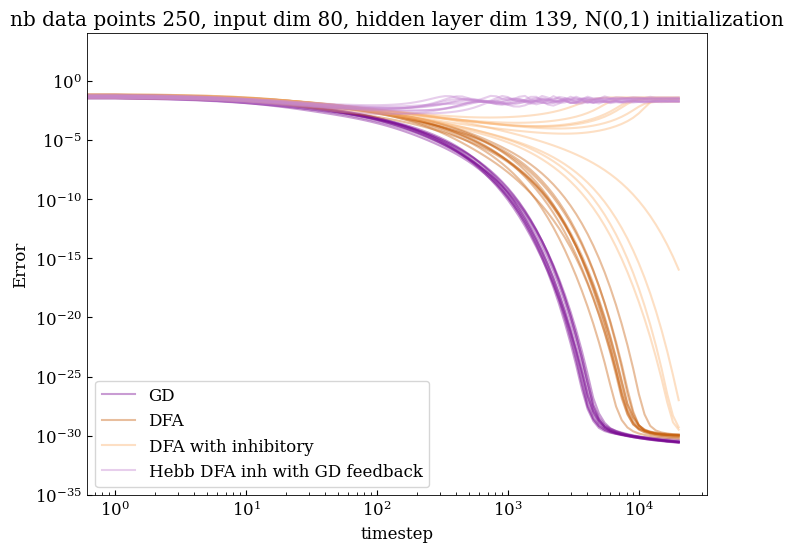

In [42]:
plt.figure(figsize=(8, 6))

for i in range(len(label_list)):
    # Plot the first run with a legend entry.
    errors = np.array(error_hist_dic[label_list[i]])[0].round(35)
    plt.plot(log_indices, errors, label=label_list[i], color=color_list[i], alpha=0.4)
    
    # Plot subsequent runs without legend entries.
    for j in range(1, nb_init):
        errors = np.array(error_hist_dic[label_list[i]])[j].round(35)
        plt.plot(log_indices, errors, color=color_list[i], alpha=0.4)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel('timestep')
plt.legend(loc='lower left')
plt.ylim((1e-35, 1e4))
plt.title('nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
          % (nb_data_points, input_dim, student_size))

# Save the figure with a lower DPI to further reduce file size
#plt.savefig('loglog_lin_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_N(0,1)_initialization.pdf' % (nb_data_points, input_dim, student_size), dpi=72)
plt.show()

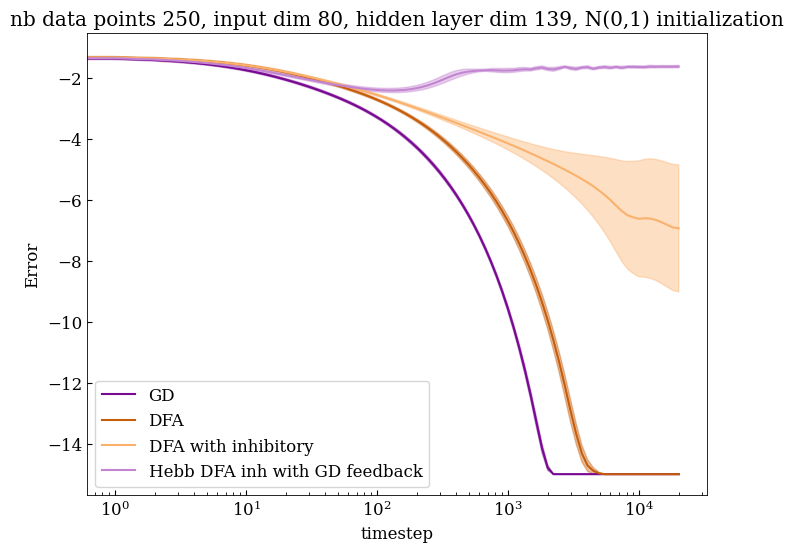

In [43]:


plt.figure(figsize=(8, 6))

for i, label in enumerate(label_list):
    # Convert error histories to a numpy array: shape (nb_init, timesteps)
    errors = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
    
    # Compute average and SEM across runs (axis 0)
    avg_error = np.mean(errors, axis=0)
    sem_error = np.std(errors, axis=0) / np.sqrt(errors.shape[0])
  

    # Plot the average error curve
    plt.plot(log_indices, avg_error, label=label, color=color_list[i])
    # Add the shaded region (mean ± SEM)
    plt.fill_between(log_indices, avg_error - sem_error, avg_error + sem_error,
                     color=color_list[i], alpha=0.4)

#plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel('timestep')
plt.legend(loc='lower left')
#plt.ylim((1e-14, 1e4))
plt.title('nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
          % (nb_data_points, input_dim, student_size))

# Save with a lower DPI to further reduce file size
#plt.savefig('avg_train_loglog_tanh_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_N(0,1)_initialization.pdf' % (nb_data_points, input_dim, student_size), dpi=72)
plt.show()


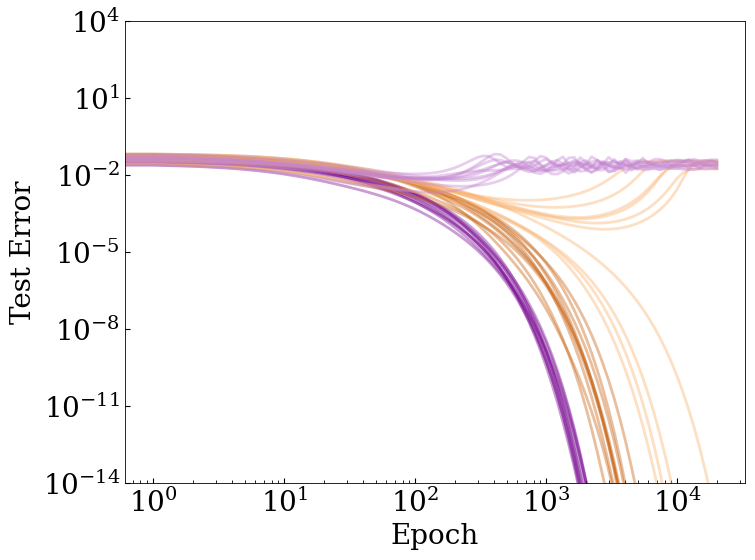

In [44]:

plt.figure(figsize=(8, 6))

for i in range(len(label_list)):
    # Plot the first run with a legend entry.
    errors = np.array(test_error_hist_dic[label_list[i]])[0].round(15)
    plt.plot(log_indices, errors, label=label_list[i], color=color_list[i], alpha=0.4, linewidth = 2)
    
    # Plot subsequent runs without legend entries.
    for j in range(1, nb_init):
        errors = np.array(test_error_hist_dic[label_list[i]])[j].round(15)
        plt.plot(log_indices, errors, color=color_list[i], alpha=0.4, linewidth =2)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Test Error', fontsize=20)
plt.xlabel('Epoch', fontsize = 20)
#plt.legend(loc='lower left')
plt.ylim((1e-14, 1e4))
#plt.title('nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
#          % (nb_data_points, input_dim, student_size))
plt.tick_params(axis='both', which='major', labelsize=20)
# Save the figure with a lower DPI to further reduce file size
#plt.savefig('tanhlearning_curves_poster_high_data_regime.pdf', dpi=300, bbox_inches='tight')
plt.show()

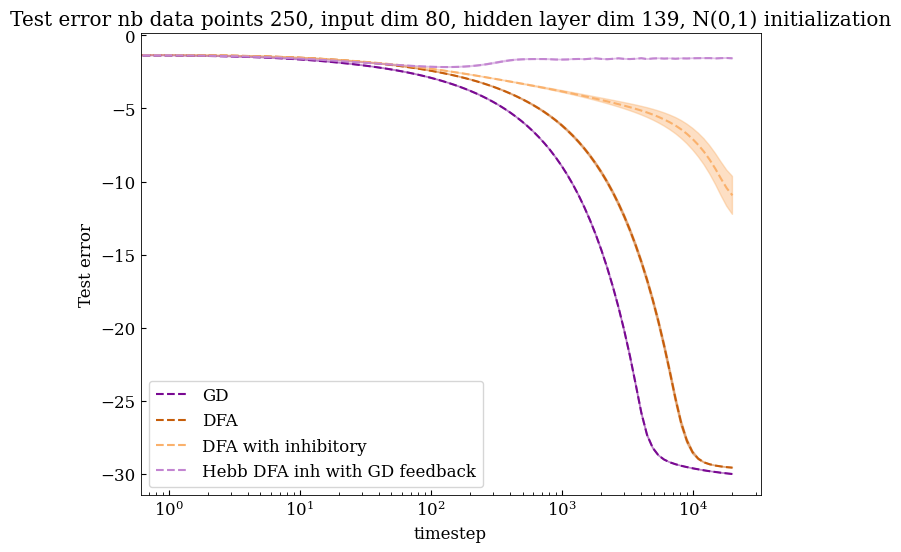

In [45]:


plt.figure(figsize=(8, 6))

for i, label in enumerate(label_list):
    # Convert error histories to a numpy array: shape (nb_init, timesteps)
    test_errors = np.log10(np.array(test_error_hist_dic[label]))#.round(15) + 1e-15)
    
    # Compute average and SEM across runs (axis 0)
    avg_error = np.mean(test_errors, axis=0)
    sem_error = np.std(test_errors, axis=0) / np.sqrt(errors.shape[0])
    
    # Plot the average error curve
    plt.plot(log_indices, avg_error, label=label, color=color_list[i], linestyle="--")
    # Add the shaded region (mean ± SEM)
    plt.fill_between(log_indices, avg_error - sem_error, avg_error + sem_error,
                     color=color_list[i], alpha=0.4)

#plt.yscale('log')
plt.xscale('log')
plt.ylabel('Test error')
plt.xlabel('timestep')
plt.legend(loc='lower left')
#plt.ylim((1e-14, 1e4))
plt.title('Test error nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
          % (nb_data_points, input_dim, student_size))

# Save with a lower DPI to further reduce file size
#plt.savefig('avg_test_loglog_tanh_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_N(0,1)_initialization.pdf' % (nb_data_points, input_dim, student_size), dpi=72)
plt.show()


In [46]:
def list_pkl_files(directory="."):
    try:
        # List all files and directories in the specified directory
        files_and_dirs = os.listdir(directory)

        # Filter out directories and non-.pkl files, keep only .pkl files
        pkl_files = [f for f in files_and_dirs if os.path.isfile(os.path.join(directory, f)) and f.endswith('.pkl')]

        return pkl_files
    except Exception as e:
        return str(e)

# Example usage
pkl_files = list_pkl_files()
len(pkl_files)

420

In [47]:
#pkl_files

In [48]:
log_indices = log_downsample_indices(nb_epochs, num_points=200)

nb_datpoints_list = []
error_hist_dic_list = []
test_error_hist_dic_list = []

#for run_nb in range(33,44):
#    with open(f'run_tanh_uniform_{run_nb}.pkl', 'rb') as f:
#        loaded_data = pickle.load(f)


filtered_list = []
c_list_L1 =  np.linspace(0.1,0.7, num = 20)#np.logspace(-1,2,20)
c_list_L2 = np.logspace(-2,1,20)

frac_list = np.linspace(0, 1, num = 21)
tot_neurons = 220

for c in c_list_L1 :
    N = int(tot_neurons/(1+c))
    M = int(tot_neurons/(1+1/c))
    
    for frac_L1 in frac_list:
        nb_AH_layer2 = 0#int(N*frac_L2) # 0
        nb_AH_layer1 = int(M*frac_L1)#0

        filtered_list.append([item for item in pkl_files if item.startswith(f'run_{nb_AH_layer1}-{M}__{nb_AH_layer2}-{N}')][0])

#[item for item in pkl_files if item.startswith('run_lin_uniform_1.')]

for file in filtered_list:
    with open(file, 'rb') as f:
        loaded_data = pickle.load(f)
    params_dic, input_list, input_test_list,  error_hist_dic, test_error_hist_dic, teacher_params  = loaded_data
    
    nb_data_points = params_dic['nb_data_points']
    nb_test_data_points = params_dic['nb_test_data_points'] 
    input_dim = params_dic['input_dim']
    teacher_size = params_dic['teacher_size']
    student_size = params_dic['student_size']
    nb_AH_layer1 = params_dic['nb_AH_layer1']
    nb_AH_layer2 = params_dic['nb_AH_layer2']
    nb_epochs = params_dic['nb_epochs']
    nb_init = params_dic['nb_init']
    nonlinearity_list = params_dic['nonlinearity_list']
    learning_rate = params_dic['learning_rate']

    nb_datpoints_list.append(nb_data_points)
    error_hist_dic_list.append(error_hist_dic.copy())
    test_error_hist_dic_list.append(test_error_hist_dic.copy())


In [49]:
tot_neurons/(1+1/c)

90.58823529411764

In [50]:
lenlist = len(nb_datpoints_list)

err_nbdat_mean = np.zeros((4,lenlist))
err_nbdat_std = np.zeros((4,lenlist))

test_err_nbdat_mean = np.zeros((4,lenlist))
test_err_nbdat_std = np.zeros((4,lenlist))

ts_train_nbdat_mean = np.zeros((4,lenlist))
ts_train_nbdat_std = np.zeros((4,lenlist))

ts_test_nbdat_mean = np.zeros((4,lenlist))
ts_test_nbdat_std = np.zeros((4,lenlist))


timestep = -1
log_indices[timestep]

19999

In [51]:
errors = np.log10(np.array(error_hist_dic_list[0]['GD']).round(15)+1e-15)

thresh =-10# -1

ts_blw_thr = find_timestep_below_threshold(errors[0], thresh = thresh)

for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
        ts_train_list = log_indices[np.array([find_timestep_below_threshold(error[k], thresh = thresh) for k in range(error.shape[0])])]
        
        ts_train_nbdat_mean[j,i] = ts_train_list.mean()
        ts_train_nbdat_std[j,i] = ts_train_list.std()
        
    
        test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)
        ts_test_list = log_indices[np.array([find_timestep_below_threshold(test_error[k], thresh = thresh) for k in range(test_error.shape[0])])]
        
        ts_test_nbdat_mean[j,i] = ts_test_list.mean()
        ts_test_nbdat_std[j,i] = ts_test_list.std()



In [52]:
for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
        err_mean = error[:,timestep].mean()
        err_std = error[:,timestep].std()

        err_nbdat_mean[j,i] = err_mean
        err_nbdat_std[j,i] = err_std
        
        
        test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)
        test_err_mean = test_error[:,timestep].mean()
        test_err_std = test_error[:,timestep].std()

        test_err_nbdat_mean[j,i] = test_err_mean
        test_err_nbdat_std[j,i] = test_err_std

In [53]:
L1_results = np.load('L1_zoom_results.npy', allow_pickle = True)
mask_mat_all_stable, mask_mat_some_stable, AH_L1_frac_list, AH_L1_upper_frac_list = L1_results.copy()

Z_th = mask_mat_all_stable.astype(int) 
x_vals = np.linspace(0.1, 0.7, num=500)
y_vals = np.linspace(0,20, mask_mat_all_stable.shape[1])

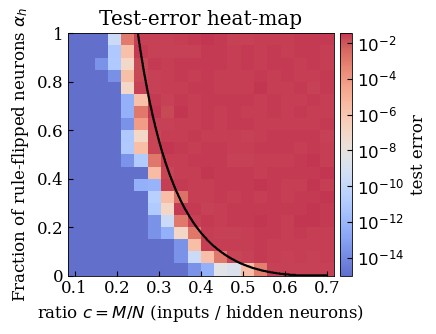

In [57]:
# -------------------------------------------------
#  Helper – edges that match a log-spaced centre list
# -------------------------------------------------
from matplotlib import colors as mcolors   # already imported as `colors`
from matplotlib import rcParams
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker


def relabel_y_as_fraction(ax, full_range, n_ticks=6):
    """
    Show the y-axis as 0→1 while keeping the original data range.

    Parameters
    ----------
    ax          : matplotlib Axes  – the axis to modify
    full_range  : float/int        – top of the raw y-axis (bottom is assumed 0)
    n_ticks     : int              – how many major ticks to place (default 5)
    """
    tick_positions = np.linspace(0, full_range, n_ticks)
    tick_labels    = np.linspace(0, 1, n_ticks)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([f"{t:.2g}" for t in tick_labels])
    
def lin_edges(vals):
    """Return an array of length N+1 whose mid-points are `vals` (length N)."""
    vals = np.asarray(vals, float)
    edges = np.empty(vals.size + 1)
    
    step_size = (vals[1:]-vals[:-1]).mean()
    
    edges[1:-1] = 1/2*(vals[:-1] + vals[1:])

    # left & right outer edges – just mirror the first/last ratio
    edges[0]  = vals[0]-step_size/2
    edges[-1] = vals[-1]+step_size/2
    return edges


rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.linewidth": 0.6,
    "axes.spines.right": True,
    "axes.spines.top": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
})

# -------------------------------------------------
#  Heat-map in the same style as the phase diagrams
# -------------------------------------------------
# 1. data

Z = np.array(test_err_nbdat_mean[3]).reshape(len(c_list_L1), len(frac_list)).T   # (rows, cols)
x_edges = lin_edges(c_list_L1)            # len = n_cols + 1
y_edges = np.arange(Z.shape[0] + 1)-1     # regular, 0 … n_rows


vmin, vmax = np.min((-0.1, np.nanmin(Z))), np.nanmax(Z)  
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=np.max((vmax,0.1)))


# 2. figure
fig, ax = plt.subplots(figsize=(4.5, 3.5))

pc = ax.pcolormesh(x_edges, y_edges[1:], Z[1:,:],
                   cmap='coolwarm', shading='flat', alpha = 0.8)#, vmin = -12, vmax = -4)#, norm=norm)      # correct cell widths


X, Ygrid = np.meshgrid(x_vals, y_vals, indexing='ij')
cs = ax.contour(X, Ygrid, Z_th,          # same X,Y,Z you already built
            levels=[0.5],         # 0 → 1 transition
            colors='k',   # pick any colour you like
            linewidths=1.5)



# 3. axes format  (identical to the phase-diagram helper)
#ax.set_xscale('log')
xticks = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
ax.set_xticks(xticks)
#ax.set_xticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$",
 #                   r"$1$", r"$10$", r"$100$"])
ax.set_xlabel(r"ratio $c=M/N$ (inputs / hidden neurons)")

ax.set_ylabel(r"Fraction of rule-flipped neurons $\alpha_h$")
relabel_y_as_fraction(ax, full_range=Z.shape[0]-1)       # keeps 0 → 1 labelling

# 4. colour-bar, title, tidy up
cbar = fig.colorbar(pc, ax=ax, pad=0.02)
cbar.set_label("test error")

tick_positions = np.arange(-2, -15, -2)      #  –2, –4, … –14
cbar.set_ticks(tick_positions)

# --- format −2 → 10^{−2}, etc. --------------------------------
fmt = mticker.FuncFormatter(lambda x, pos: rf"$10^{{{int(x)}}}$")
cbar.ax.yaxis.set_major_formatter(fmt)


ax.set_title("Test-error heat-map")
plt.tight_layout()

#fig.savefig("zoom_test_error_wtheory_heatmap_L1.svg", dpi=300, bbox_inches="tight", transparent= True)
#fig.savefig("zoom_test_error_wtheory_heatmap_L1.pdf", dpi=300, bbox_inches="tight", transparent= True)


In [55]:
x_edges

array([0.08421053, 0.11578947, 0.14736842, 0.17894737, 0.21052632,
       0.24210526, 0.27368421, 0.30526316, 0.33684211, 0.36842105,
       0.4       , 0.43157895, 0.46315789, 0.49473684, 0.52631579,
       0.55789474, 0.58947368, 0.62105263, 0.65263158, 0.68421053,
       0.71578947])

In [56]:
c_list_L1

array([0.1       , 0.13157895, 0.16315789, 0.19473684, 0.22631579,
       0.25789474, 0.28947368, 0.32105263, 0.35263158, 0.38421053,
       0.41578947, 0.44736842, 0.47894737, 0.51052632, 0.54210526,
       0.57368421, 0.60526316, 0.63684211, 0.66842105, 0.7       ])